In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

%load_ext autoreload
%autoreload 2
from utils import show_heat_map, print_mutual_info, aggregate_data, resample_df, load_big_df
from utils import two_sig_signal, two_sig_signal_multi, get_yulu_df, nice_hist_series, plot_box_plot
from utils import plot_box_plot_a, get_future_df

from lin_regr_utils import lin_regr, linearity_test, residual_independence_test, homoscedasticity_test, residual_normality_test
from lin_regr_utils import multicollinearity_test, get_stats

# import warnings
# warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
df_raw = pd.read_csv("../simulation_data/output_20250414_GALAUSDTOB500_GALAUSDTtrades_AA.csv")
# df_raw
df = df_raw

In [142]:
# df
df_buy, df_sell, df_ob = aggregate_data(df)
# df_ob
# df_sell
# df_sell

df_buy = df_buy.rename(columns={x:'buy_'+ x for x in df_buy.columns})
df_sell = df_sell.rename(columns={x:'sell_'+ x for x in df_sell.columns})
print(df_ob.columns)
print(df_sell.columns)
print(df_buy.columns)

dff = df_ob.join(df_buy.join(df_sell, how='outer'), how='outer')
# dff

Index(['bbid', 'bask', 'bsize', 'asize'], dtype='object')
Index(['sell_trade_size_sum', 'sell_trade_price_min', 'sell_trade_price_max'], dtype='object')
Index(['buy_trade_size_sum', 'buy_trade_price_min', 'buy_trade_price_max'], dtype='object')


In [137]:
def add_future_columns(df_raw):
    df_raw = df_raw.copy()
    # df_buy, df_sell, df_ob = aggregate_data(df_raw)

    # df_buy = df_buy.rename(columns={x:'buy_'+ x for x in df_buy.columns})
    # df_sell = df_sell.rename(columns={x:'sell_'+ x for x in df_sell.columns})

    # dff = df_ob.join(df_buy.join(df_sell, how='outer'), how='outer')
    # fdf = get_future_df(dff.reset_index(), '5s')

    df_raw['time'] = pd.to_datetime(df_raw['time'], unit='s')
    df_raw['round_time'] = df_raw['time'].dt.round(interval)

    rdf = df_raw.set_index('time', inplace=False).resample(interval).last()
    rdf.loc[:,'mid'] = (rdf['bbid'] + rdf['bask']) / 2
    
    rdf.loc[:,'future_1m_mid'] = rdf['mid'].shift(-60)
    rdf.loc[:,'future_1m_return'] = np.log(rdf['mid'].shift(-60)/rdf['mid'])
    rdf.loc[:,'future_1m_std'] = rdf['mid'].shift(-60).rolling(60).std()
    rdf.loc[:,'future_1m_range'] = rdf['mid'].shift(-60).rolling(60).max() - rdf['mid'].shift(-60).rolling(60).min()

    rdf.loc[:,'past_1m_return'] = np.log(rdf['mid']/rdf['mid'].shift(60))

    rrdf = rdf[['future_1m_mid', 'future_1m_return', 'future_1m_std', 'future_1m_range', 'past_1m_return']].reset_index()
    rrdf = rrdf.rename(columns={'time': 'r_time'})

    df_raw_r = pd.merge(df_raw, rrdf, left_on='round_time', right_on='r_time', how='left') #.drop(columns=['r_time'])
    return

SyntaxError: unexpected EOF while parsing (<ipython-input-137-e2f6af1e704a>, line 1)

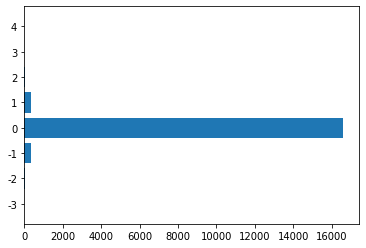

4 3 3 12.450000000000001
3 15 18 56.699999999999996
2 61 79 169.85
1 377 456 524.4
0 16586 17042 2556.2999999999997


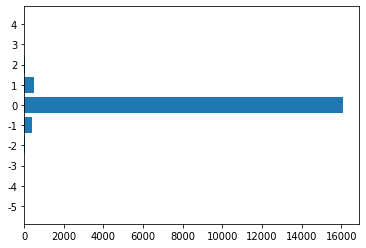

4 1 1 4.15
3 3 4 12.6
2 41 45 96.75
1 501 546 627.9
0 16086 16632 2494.7999999999997
456 546 1002


In [143]:
dff['bbid'] = dff['bbid'].ffill()
dff['bask'] = dff['bask'].ffill()
dff[:100]

bdf = dff.dropna(subset=['buy_trade_size_sum'])

bd = dict((bdf['buy_trade_price_max'] - bdf['bask']).value_counts())
nbd = {}
for k,v in bd.items():
    kk = round(k*100000)
    if not kk in nbd:
        nbd[kk] = v
    else:
        nbd[kk] += v

snbd = dict(sorted(list(nbd.items())))

keys = [str(x) for x in list(snbd.keys())]
values = list(snbd.values())
plt.barh(keys, values)
plt.show()

sumv = 0
for k, v in list(snbd.items())[::-1]:
    if k>=0:
        sumv += v
        print(k, v, sumv, (k+0.15)*sumv)

bsum = sum([v for k, v in snbd.items() if k>=1])

sdf = dff.dropna(subset=['sell_trade_size_sum'])

bd = dict((sdf['bbid'] - sdf['sell_trade_price_min']).value_counts())
nbd = {}
for k,v in bd.items():
    kk = round(k*100000)
    if not kk in nbd:
        nbd[kk] = v
    else:
        nbd[kk] += v

snbd = dict(sorted(list(nbd.items())))

keys = [str(x) for x in list(snbd.keys())]
values = list(snbd.values())
plt.barh(keys, values)
plt.show()
# print(snbd.items())

sumv = 0
for k, v in list(snbd.items())[::-1]:
    if k>=0:
        sumv += v
        print(k, v, sumv, (k+0.15)*sumv)

ssum = sum([v for k, v in snbd.items() if k>=1])

print(bsum, ssum, bsum + ssum)
# print(dict((bdf['buy_trade_price_max'] - bdf['bask']).value_counts()))
# plt.hist(bdf['buy_trade_price_max'] - bdf['bask'], bins=30)
# plt.xticks(rotation=45)
# plt.show()

# sdf = dff.dropna(subset=['sell_trade_size_sum'])
# plt.hist(sdf['bbid'] - sdf['sell_trade_size_sum'], bins=30)
# plt.xticks(rotation=45)
# plt.show()

fdf: Index(['time', 'bbid', 'bask', 'bsize', 'asize', 'buy_trade_size_sum',
       'buy_trade_price_min', 'buy_trade_price_max', 'sell_trade_size_sum',
       'sell_trade_price_min', 'sell_trade_price_max', 'round_time', 'r_time',
       'future_1m_mid', 'future_1m_return', 'future_1m_std', 'future_1m_range',
       'past_1m_return'],
      dtype='object')
159, 2.00, 4.96, 317.50


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


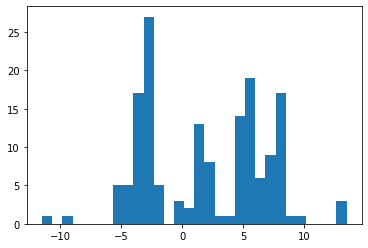

182, -0.48, 4.86, -88.00


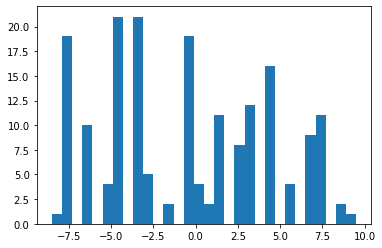

182, -1.98, 4.86, -361.00


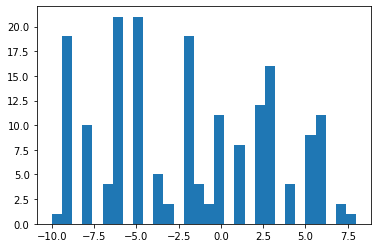

In [144]:
# dff.iloc[300:400]
# bdf

fdf = get_future_df(dff.reset_index(), '5s')
print("fdf:", fdf.columns)
# bdf = dff.dropna(subset=['buy_trade_size_sum'])

EDGE = 1

fbdf = fdf.dropna(subset=['buy_trade_size_sum'])
tick_edge_bdf = fbdf[fbdf['buy_trade_price_max'] - fbdf['bask'] >= 0.00001 * EDGE]
tick_edge_bdf.loc[:,'pnl'] = (tick_edge_bdf['bask'] + 0.00001 * EDGE - tick_edge_bdf['future_1m_mid']) * 100000

tick_edge_bdf.loc[:,'mid'] = (tick_edge_bdf['bbid'] + tick_edge_bdf['bask']) / 2
tick_edge_bdf.loc[:,'sprd'] = (tick_edge_bdf['bask'] - tick_edge_bdf['bbid']) * 100000
tick_edge_bdf.loc[:,'mid_pnl'] = (tick_edge_bdf['mid'] - tick_edge_bdf['future_1m_mid']) * 100000

plt.hist(tick_edge_bdf['pnl'], bins=30)
print(f"{tick_edge_bdf['pnl'].count()}, {tick_edge_bdf['pnl'].mean():.2f}, {tick_edge_bdf['pnl'].std():.2f}, {tick_edge_bdf['pnl'].sum():.2f}")
plt.show()
# plt.hist(tick_edge_bdf['mid_pnl'], bins=30)
# print(f"{tick_edge_bdf['mid_pnl'].count()}, {tick_edge_bdf['mid_pnl'].mean():.2f}, {tick_edge_bdf['mid_pnl'].std():.2f}, {tick_edge_bdf['mid_pnl'].sum():.2f}")
# plt.show()

# plt.show()
# plt.hist(tick_edge_bdf['sprd'], bins=30)
# print(f"{tick_edge_bdf['sprd'].count()}, {tick_edge_bdf['sprd'].mean():.2f}, {tick_edge_bdf['sprd'].std():.2f}, {tick_edge_bdf['sprd'].sum():.2f}")

fsdf = fdf.dropna(subset=['sell_trade_size_sum'])
tick_edge_sdf = fsdf[fsdf['bbid'] - fsdf['sell_trade_price_min'] >= 0.00001 * EDGE]
tick_edge_sdf.loc[:,'pnl'] = (tick_edge_sdf['future_1m_mid'] - tick_edge_sdf['bbid'] + 0.00001 * EDGE) * 100000

tick_edge_sdf.loc[:,'mid'] = (tick_edge_sdf['bbid'] + tick_edge_sdf['bask']) / 2
tick_edge_sdf.loc[:,'sprd'] = (tick_edge_sdf['bask'] - tick_edge_sdf['bbid']) * 100000
tick_edge_sdf.loc[:,'mid_pnl'] = (tick_edge_sdf['future_1m_mid'] - tick_edge_sdf['mid']) * 100000

plt.hist(tick_edge_sdf['pnl'], bins=30)
print(f"{tick_edge_sdf['pnl'].count()}, {tick_edge_sdf['pnl'].mean():.2f}, {tick_edge_sdf['pnl'].std():.2f}, {tick_edge_sdf['pnl'].sum():.2f}")
plt.show()
plt.hist(tick_edge_sdf['mid_pnl'], bins=30)
print(f"{tick_edge_sdf['mid_pnl'].count()}, {tick_edge_sdf['mid_pnl'].mean():.2f}, {tick_edge_sdf['mid_pnl'].std():.2f}, {tick_edge_sdf['mid_pnl'].sum():.2f}")
plt.show()


In [96]:
fdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636928 entries, 0 to 636927
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   time                  636928 non-null  datetime64[ns]
 1   bbid                  636928 non-null  float64       
 2   bask                  636928 non-null  float64       
 3   bsize                 606235 non-null  float64       
 4   asize                 606235 non-null  float64       
 5   round_time            636928 non-null  datetime64[ns]
 6   buy_trade_size_sum    15575 non-null   float64       
 7   buy_trade_price_min   15575 non-null   float64       
 8   buy_trade_price_max   15575 non-null   float64       
 9   sell_trade_size_sum   15167 non-null   float64       
 10  sell_trade_price_min  15167 non-null   float64       
 11  sell_trade_price_max  15167 non-null   float64       
 12  r_time                63129 non-null   datetime64[ns]
 13 

In [ ]:
def get_yulu_df():
    def process(df_raw):
        df_raw = df_raw[['time', 'mid', 'trade_side', 'trade_size', 'trade_price']]
        # display(df_raw)

        df_raw['mul'] = df_raw['trade_size'] * df_raw['trade_price']
        df_raw['time'] = pd.to_datetime(df_raw['time'], unit='s')

        # Group by 'time' and conditionally sum 'A' based on 'B' == 'X'
        df_buy = df_raw[df_raw['trade_side'] == 'Buy'].groupby('time', as_index=False).agg(
            trade_mul_sum=('mul', 'sum'),
            trade_size_sum=('trade_size', 'sum'),
        )
        df_sell = df_raw[df_raw['trade_side'] == 'Sell'].groupby('time', as_index=False).agg(
            trade_mul_sum=('mul', 'sum'),
            trade_size_sum=('trade_size', 'sum'),
        )

        df_buy.set_index('time', inplace=True)
        df_sell.set_index('time', inplace=True)

        df_ob = df_raw[df_raw['trade_side'].isna()].drop(columns=['trade_side', 'trade_size', 'trade_price'])
        df_ob.set_index('time', inplace=True)

        time_step = '1T'
        # SUM_TRADE_SIZE = df_raw['trade_size'].sum()
        df_buy_resampled = df_buy.resample(time_step).agg({
                'trade_size_sum': 'sum',  # Sum for size
                'trade_mul_sum': 'sum',  # Min for min price
            }).rename(columns={'trade_size_sum': 'buy_size', 'trade_mul_sum': 'buy_mul'})
        df_sell_resampled = df_sell.resample(time_step).agg({
                'trade_size_sum': 'sum',  # Sum for size
                'trade_mul_sum': 'sum',  # Min for min price
            }).rename(columns={'trade_size_sum': 'sell_size', 'trade_mul_sum': 'sell_mul'})
        df_ob_resampled = df_ob.resample(time_step).last()
        df = df_ob_resampled.join(df_buy_resampled.join(df_sell_resampled, how='outer'), how='outer')

        for col in ['buy_size', 'sell_size']:
            df[col] = df[col].fillna(0)

        for col in ['mid']:
            df[col] = df[col].ffill()  
        return df

    from tqdm import tqdm
    start_date_str = "20250213"
    end_date_str = "20250314"
    name_template = "output_2025-03-15_{}_HYPEUSDTOB500_HYPEUSDTtrades_VX.csv"

    big_df = []

    start_date = datetime.strptime(start_date_str, "%Y%m%d")
    end_date = datetime.strptime(end_date_str, "%Y%m%d")

    date_range = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]

    for date in tqdm(date_range):
        date_str = date.strftime('%Y%m%d')
        filename = name_template.format(date_str)
        df_raw = pd.read_csv(f"../simulation_data/{filename}")
        df1 = process(df_raw)
        # df_buy, df_sell, df_ob = aggregate_data(df_raw)
        # df = resample_df(df_buy, df_sell, df_ob, '30s')
        big_df.append(df1)

    df2 = pd.concat(big_df, axis=0, ignore_index=False)
    df2.to_csv('dataframes/HYPEUSDT_mar16_yulu.csv', index=True)

    df2['vwap'] = (df2['buy_mul'] + df2['sell_mul']) / (df2['buy_size'] + df2['sell_size'])
    df2['alpha1'] = 1.0 * (df2['vwap'] - df2['mid'])
    df2['alpha2'] = df2['alpha1'].ewm(span=3, adjust=False).mean()
    return df2

In [67]:
def process_yulu(df_raw, time_step='1T'):
    df_raw = df_raw[['time', 'mid', 'trade_side', 'trade_size', 'trade_price']]
    # display(df_raw)

    df_raw['mul'] = df_raw['trade_size'] * df_raw['trade_price']
    df_raw['time'] = pd.to_datetime(df_raw['time'], unit='s')

    # Group by 'time' and conditionally sum 'A' based on 'B' == 'X'
    df_buy = df_raw[df_raw['trade_side'] == 'Buy'].groupby('time', as_index=False).agg(
        trade_mul_sum=('mul', 'sum'),
        trade_size_sum=('trade_size', 'sum'),
    )
    df_sell = df_raw[df_raw['trade_side'] == 'Sell'].groupby('time', as_index=False).agg(
        trade_mul_sum=('mul', 'sum'),
        trade_size_sum=('trade_size', 'sum'),
    )

    df_buy.set_index('time', inplace=True)
    df_sell.set_index('time', inplace=True)

    df_ob = df_raw[df_raw['trade_side'].isna()].drop(columns=['trade_side', 'trade_size', 'trade_price'])
    df_ob.set_index('time', inplace=True)

    # time_step = '1T'
    # SUM_TRADE_SIZE = df_raw['trade_size'].sum()
    df_buy_resampled = df_buy.resample(time_step).agg({
            'trade_size_sum': 'sum',  # Sum for size
            'trade_mul_sum': 'sum',  # Min for min price
        }).rename(columns={'trade_size_sum': 'buy_size', 'trade_mul_sum': 'buy_mul'})
    df_sell_resampled = df_sell.resample(time_step).agg({
            'trade_size_sum': 'sum',  # Sum for size
            'trade_mul_sum': 'sum',  # Min for min price
        }).rename(columns={'trade_size_sum': 'sell_size', 'trade_mul_sum': 'sell_mul'})
    df_ob_resampled = df_ob.resample(time_step).last()
    df = df_ob_resampled.join(df_buy_resampled.join(df_sell_resampled, how='outer'), how='outer')

    for col in ['buy_size', 'sell_size']:
        df[col] = df[col].fillna(0)

    for col in ['mid']:
        df[col] = df[col].ffill()  
    return df

<ipython-input-67-ea538cfc1cd1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['mul'] = df_raw['trade_size'] * df_raw['trade_price']
<ipython-input-67-ea538cfc1cd1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['time'] = pd.to_datetime(df_raw['time'], unit='s')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 704127 entries, 0 to 704126
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   time         704127 non-null  datetime64[ns]
 1   bbid         606235 non-null  float64       
 2   bask         606235 non-null  float64       
 3   bsize        606235 non-null  float64       
 4   asize        606235 non-null  float64       
 5   trade_side   97892 non-null   object        
 6   trade_size   97892 non-null   float64       
 7   trade_price  97892 non-null   float64       
 8   round_time   704127 non-null  datetime64[ns]
 9   r_time       704127 non-null  datetime64[ns]
 10  mid          704127 non-null  float64       
 11  mul          0 non-null       float64       
 12  buy_size     704127 non-null  float64       
 13  buy_mul      703798 non-null  float64       
 14  sell_size    704127 non-null  float64       
 15  sell_mul     703925 non-null  floa

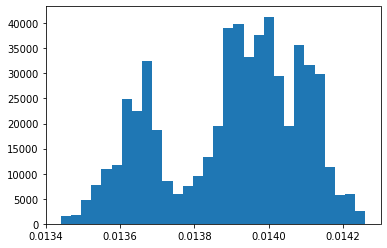

In [73]:
TIME_STEP = '10S'

ydf = df_raw[df_raw.columns]
ydf['mid'] = (ydf['bbid'] + ydf['bask']) / 2

df1 = process_yulu(ydf, TIME_STEP)
df1['vwap'] = (df1['buy_mul'] + df1['sell_mul']) / (df1['buy_size'] + df1['sell_size'])
df1['alpha'] = np.log(df1['vwap'].rolling(5).mean() / df1['vwap'].rolling(20).mean())
fdf1 = get_future_df_yulu(df_raw, df1.reset_index(), TIME_STEP)

plt.hist(fdf1['vwap'], bins=30)
fdf1.info()

In [66]:
def get_future_df_yulu(df_raw, ref_df, interval='1S'):
    df_raw['time'] = pd.to_datetime(df_raw['time'], unit='s')
    df_raw['round_time'] = df_raw['time'].dt.round(interval)
    
    rrdf = ref_df.rename(columns={'time': 'r_time'})

    df_raw_r = pd.merge(df_raw, rrdf, left_on='round_time', right_on='r_time', how='left') #.drop(columns=['r_time'])
    return df_raw_r

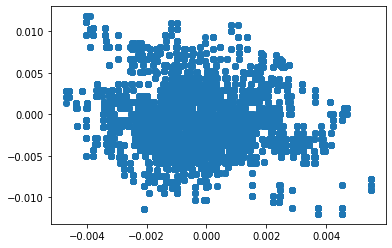

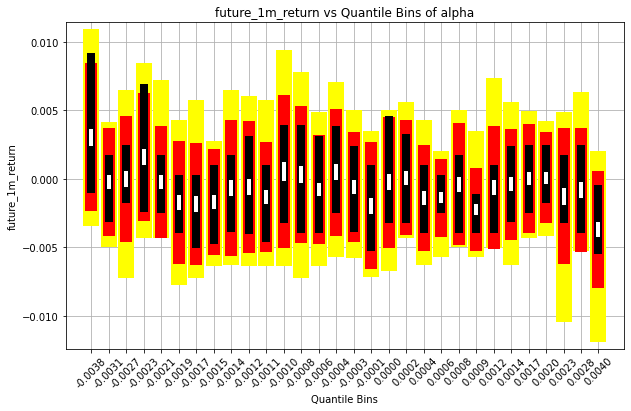

In [82]:
dff.iloc[300:400]
# bdf

fdf11 = get_future_df(fdf1.reset_index(), '5S')

# bdf = dff.dropna(subset=['buy_trade_size_sum'])
# fbdf = fdf.dropna(subset=['buy_trade_size_sum'])

# EDGE = 1

# tick_edge_bdf = fbdf[fbdf['buy_trade_price_max'] - fbdf['bask'] >= 0.00001 * EDGE]
# tick_edge_bdf['pnl'] = (tick_edge_bdf['bask'] + 0.00001 * EDGE - tick_edge_bdf['future_1m_mid']) * 100000
# tick_edge_bdf['mid_pnl'] = (tick_edge_bdf['future_1m_mid'] - tick_edge_bdf['mid']) * 100000
# plt.hist(tick_edge_bdf['pnl'], bins=30)
# print(f"{len(tick_edge_bdf)}, {tick_edge_bdf['pnl'].mean():.2f}, {tick_edge_bdf['pnl'].std():.2f}, {tick_edge_bdf['pnl'].sum():.2f}")
fdf11.columns

plt.scatter(fdf11['alpha'], fdf11['future_1m_return'])

plot_box_plot_a(fdf11, 'alpha', 'future_1m_return')

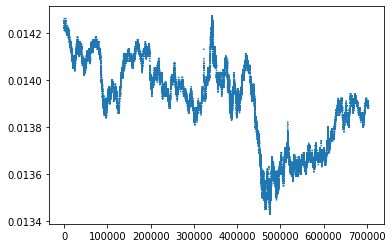

In [102]:
plt.plot(df_raw['bbid'])